In [33]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#CSV file with the coordinates of the RF towers
DATACSV = "towerConfig.csv"

In [34]:
#Node class stores the attributes of the fire tower
#The location of the tower in cartesian coordinates are the relevant attributes 
class Node:
    def __init__(self, x_coord, y_coord):
        self.x_coord = x_coord
        self.y_coord = y_coord

#The path class stores the attributes of a path between two arbitrary nodes
#The slope of the path M and the y intercept B are the relevant attributes
class Path:
    def __init__(self, node1, node2):
        self.node1 = node1
        self.node2 = node2

        #Finding the slope of line connecting the two nodes
        dy = self.node2.y_coord - self.node1.y_coord
        dx = self.node2.x_coord - self.node1.x_coord

        #finding the path length
        self.length = (dy**2 + dx**2)**0.5

        #Edge case: infinite slope
        if dx == 0:
            if dy >= 0:
                self.slope = float("inf")
            else:
                self.slope = float("-inf")
        #Normal case
        else:
            self.slope = dy/dx
        
        #Finding the y_intercept of the line connecting the two nodes
        #Edge case: infinite slope
        if self.slope == float("inf") or self.slope == float("-inf"):
            self.y_int = None
        #Normal case
        else:
            self.y_int = node1.y_coord - self.slope*node1.x_coord

#The contour of the forest defined by x-y coordinates of towers along its perimeter
contour = np.array([])

#The towers along the contour of the forest
nodes = np.array([])

#Valid paths between nodes
paths = np.array([])

#The intersection points between nodes
intersects = np.array([])

In [35]:
#Check if a path overlaps a given node
def pathOverlaps(path, node):
    
    #Edge case: parent node
    if path.node1 == node or path.node2 == node:
        return False

    #Edge case: zero slope
    if path.slope == 0:
        if path.y_int == node.y_coord:
            return True
        else:
            return False
    
    #Edge case: infinite slope
    if path.slope == float("inf") or path.slope == float("-inf"):
        if path.node1.x_coord == node.x_coord:
            return True
        else:
            return False
    
    #Main case
    #Compare x and y coordinates
    y_coord = node.y_coord
    x_coord = (y_coord - path.y_int)/path.slope
    if (x_coord == node.x_coord):
        return True
    else:
        return False

#Check if two non-parallel paths intersect within the contour
def pathsIntersect(path1, path2):

    #Coordinates of point of intersection
    x_intersect = 0
    y_intersect = 0

    #Edge case: both paths have infinite slope
    if (path1.slope == float("inf") or path1.slope == float("-inf")) and (path2.slope == float("inf") or path2.slope == float("-inf")):
        return False, None, None
    
    #Edge case: both paths have the same slope
    elif (path1.slope == path2.slope):
        return False, None, None
    
    #Edge case: one path has infinite slope
    elif (path1.slope == float("inf") or path1.slope == float("-inf")):
        x_intersect = path1.node1.x_coord
        y_intersect = path2.slope*x_intersect + path2.y_int
    
    elif (path2.slope == float("inf") or path2.slope == float("-inf")):
        x_intersect = path2.node1.x_coord
        y_intersect = path1.slope*x_intersect + path1.y_int
    
    #Find the x and y values of the point of intersection
    else:
        x_intersect = (path2.y_int - path1.y_int)/(path1.slope - path2.slope)
        y_intersect = path1.slope*x_intersect + path1.y_int

    
    #Determine if the points of intersection are within bounds
    dist = cv2.pointPolygonTest(contour, (int(x_intersect), int(y_intersect)), True)

    if dist >= 0:
        return True, x_intersect, y_intersect
    else:
        return False, None, None

### Processing

In [36]:
data = pd.read_csv("towerConfig.csv")
tower_x_coords = data["x_coord"]
tower_y_coords = data["y_coord"]

#Create contour
contour = np.array([[tower_x_coords[i], tower_y_coords[i]] for i in range(len(tower_x_coords))])

#Create nodes
nodes = np.array([Node(tower_x_coords[i], tower_y_coords[i]) for i in range(len(tower_x_coords))])

#Initialize paths 
allPaths = np.array([])
for node1 in nodes:
    for node2 in nodes:
        if node1 == node2:
            continue
        else:
            allPaths = np.append(allPaths, Path(node1, node2))

#Check validity of paths and create intersects
for path in allPaths:
    
    #Check if the path overlaps a node
    overlap = False
    for node in nodes:
        if pathOverlaps(path, node):
            overlap = True
    
    if overlap:
        continue
    
    #Check if the path intersects another path
    intersect = False
    x = 0
    y = 0
    for otherPath in allPaths:
        if path == otherPath:
            continue
        else:
            intersect, x, y = pathsIntersect(path, otherPath)
    
    if intersect:
        paths = np.append(paths, path)
        intersects = np.append(intersects, [x, y])

### Plotting

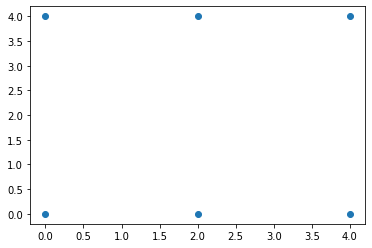

In [37]:
plt.figure()
plt.scatter(tower_x_coords, tower_y_coords)
plt.show()